<a href="https://colab.research.google.com/github/Brian16Park/LSTM_Project/blob/main/LSTM_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Stock Prediction Using LSTM**
###**By Brian Park and Yang Lu**

Youtube Guide: https://youtu.be/94PlBzgeq90?si=HqLrjtbVcEJw-K7n

**Goal:** Trying to predict the Stock Price of Microsoft using historical data. Creating a Time Series Analysis Model using LTSM. Improving the youtube guide.

**LSTM** - Long Short-Term Memory
A type of recurrent neural network (RNN) designed to better handle sequences of data, especially when long-term dependencies are important.

When to use LSTM?
1.   Time Series Prediction
2.   NLP
3.   Speech Recognition

**Note:** LSTMs have special units called memory cells, which allow them to remember information for longer periods compared to traditional RNNS.

**Gates:** LSTMs use three types of gates:
*   Forget Gate: Decides which information to discard from the cell state.
*   Input Gate: Updates the cell state with new information.
*   Output Gate: Determines what the next hidden state will be, which influences the output and the next time step.





In [ ]:
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

# keras - Used for building and training neural networks
# StandardScaler - standardizes numerical features by scaling them to have mean and variance.
# numpy - Numerical Python to better handle vast amounts of numerical data.
# seaborn - Advanced version of Mathplotlib with better tools for visualizations.


##Setting the Seed For Similar Runs

In [ ]:
os.environ["PYTHONHASHSEED"] = '0'
random.seed(3)
np.random.seed(3)
tf.random.set_seed(3)

# 1, 2,

##Mounting on Google Drive

Accessing files in google colab is through google drive.


In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")

data_dir = "/content/drive/MyDrive/Microsoft_Stock_Data"
stock_file = "MicrosoftStock.csv"

stock_path = os.path.join(data_dir, stock_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv(stock_path)

print(data.head())
print(data.info())
print(data.describe())

    index        date   open   high    low  close    volume  Name
0  390198  2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199  2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200  2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201  2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202  2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB
None
               index         open         high          low 

##Checking for Missing Values

We check for missing values but there is none.

In [ ]:
missing = data.isnull().sum().reset_index()
missing.columns = ["Column", "Missing Values"]
print("Missing Values by Column")
print("\n", missing)

Missing Values by Column

    Column  Missing Values
0   index               0
1    date               0
2    open               0
3    high               0
4     low               0
5   close               0
6  volume               0
7    Name               0


##Initial Data Visualization

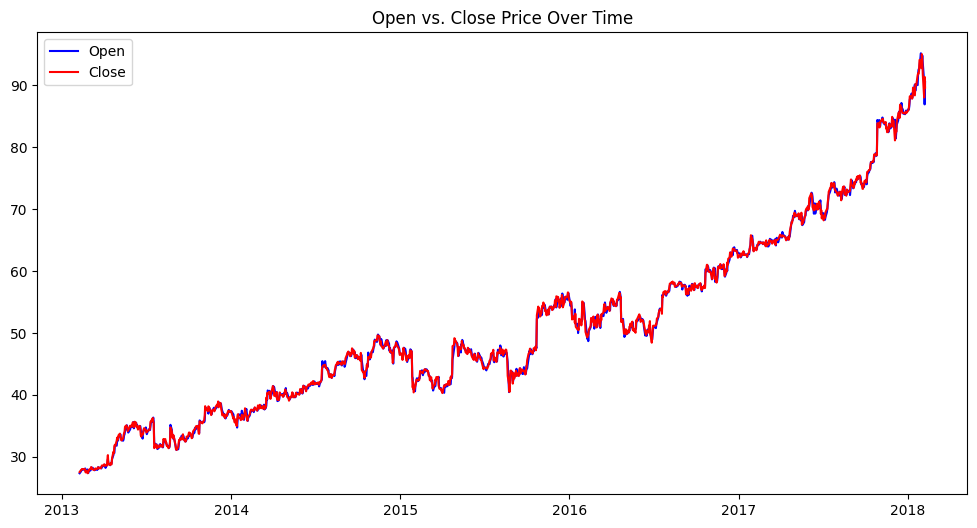

In [ ]:
# First, we need to convert the date to datetime
data["date"] = pd.to_datetime(data["date"])

# Plot 1 - Open and Close Prices of time
fig = plt.figure(figsize = (12, 6))
plt.plot(data["date"], data["open"], label = "Open", color = "blue")
plt.plot(data["date"], data["close"], label = "Close", color = "red")

plt.title("Open vs. Close Price Over Time")
plt.legend()
plt.show()

This graph is showing us an almost perfect overlap, meaning the difference between the opening and closing price each day is very small relative to the overall price level. Also, showing a positive trend.

There are a few mini "dips" or sideways phases where the price stalls or pulls back briefly, but each is followed by a new run higher.

##Plot 2 - Trading Volume (check for outliers)

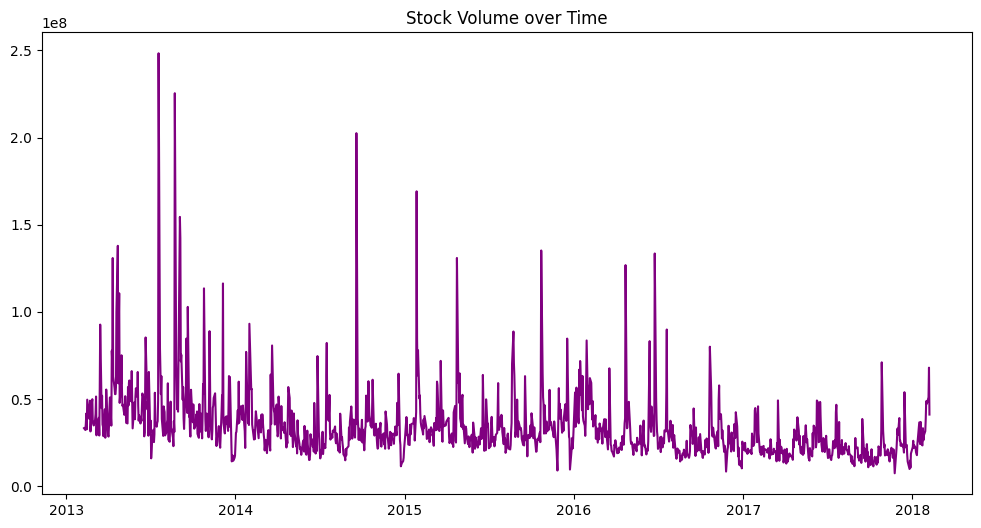

In [ ]:
fig = plt.figure(figsize = (12, 6))
plt.plot(data["date"], data["volume"], label = "Volume", color = "purple")

plt.title("Stock Volume over Time")
plt.show()

This graph is showing me that there are a handful of extreme outliers.

##Plot 3 - Correlation Matrix

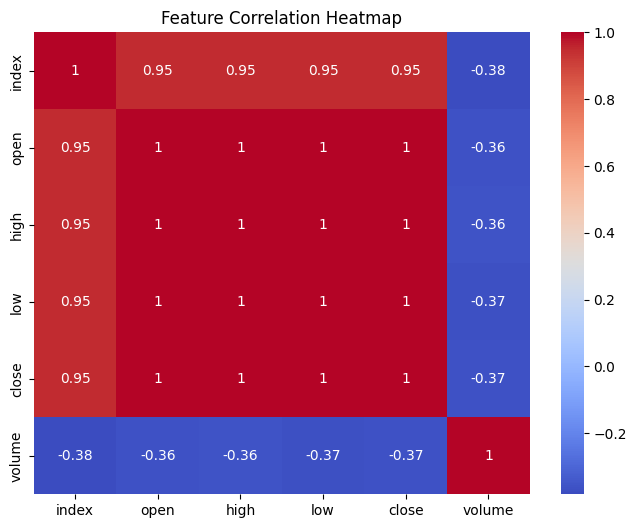

In [ ]:
# Drop non-numeric columns
numeric_data = data.select_dtypes(include = ["int64", "float64"])

# Plot 3 - Check for correlation between features
plt.figure(figsize = (8, 6))
sns.heatmap(numeric_data.corr(), annot = True, cmap = "coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In this correlation heatmap, every feature other than volume are highly correlated with each other. The volume feature is modest and inversely correlated with the other features.

#Steps:

**Build a Time Series Model**

We first need to setup a model with Sequential type. We need to build out layers on the model.

**First Layer:** This is like a brain to help the model understand patterns.
*   Number 64 - The number of memory cells. Higher number, the more complex problems
*   return_sequence - After done, give me the full list of ideas for the next layer.
*   input_shape - Tells the first LSTM layer what kind of data to expect.

**Second Layer:** This is another brain, but this time it only gives the final idea, not a list of thoughts.
*   Number 64
*   return_sequence

**Dense Layer:** turns complex patterns into a decision.
*   Number 128 - Neural Network layer with 128 neurons to help make the final decision.
*   activation - helps the model introduce non-linearity (ReLU).

**Dropout Layer:** This layer randomly drops out 50% of the neurons during training. This prevents overfitting.

**Final Dense Layer:** This layer makes the final prediction. A simple layer with 1 neuron that outputs one value - the predicted stock price.

**Model Compilation:** Compiling the model to tell it how to learn. We use an Adam optimizer since it works well with time-series data. We use MAE loss function to measure how far the predictions are from the actual price. The lower the MAE, the better.

#Model 1 Summary

This model built from the youtube guide did good on the next stock predictions. However, the only big issue of this model is the data leakage in the scaling step. This person scaled the entire dataset (train + test). By scaling the whole dataset, this person lets information from the test portion to leak into the training preprocessing (mean + std). This will most likely always give you optimistic evaluation metrics.

Not in the youtube guide, but I added a validation set and an early stopping technique. A validation set to prevent overfitting and simulate unseen data during training. An early stopping technique which monitors a validation metric for each epoch and watches for improvements. In other words, it prevents overfitting by cutting off training once your model starts to specialize too much on the training set at the expense of generalization. This would even save computation.

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4782 - root_mean_squared_error: 0.5698

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.4661 - root_mean_squared_error: 0.5583 - val_loss: 0.8155 - val_root_mean_squared_error: 0.8578
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2654 - root_mean_squared_error: 0.3145

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.2624 - root_mean_squared_error: 0.3117 - val_loss: 0.3395 - val_root_mean_squared_error: 0.3847
Epoch 3/100
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2004 - root_mean_squared_error: 0.2428

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.1966 - root_mean_squared_error: 0.2392 - val_loss: 0.2444 - val_root_mean_squared_error: 0.2787
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1672 - root_mean_squared_error: 0.2059

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.1657 - root_mean_squared_error: 0.2043 - val_loss: 0.0942 - val_root_mean_squared_error: 0.1361
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.2406 - root_mean_squared_error: 0.2877 - val_loss: 0.3652 - val_root_mean_squared_error: 0.4008
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.1590 - root_mean_squared_error: 0.1968 - val_loss: 0.1715 - val_root_mean_squared_error: 0.2091
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.1393 - root_mean_squared_error: 0.1724 - val_loss: 0.1756 - val_root_mean_squared_error: 0.2050
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1443 - root_mean_squared_error: 0.1772

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.1432 - root_mean_squared_error: 0.1760 - val_loss: 0.0874 - val_root_mean_squared_error: 0.1255
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.1738 - root_mean_squared_error: 0.2118 - val_loss: 0.3298 - val_root_mean_squared_error: 0.3601
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.1274 - root_mean_squared_error: 0.1583 - val_loss: 0.2718 - val_root_mean_squared_error: 0.3025
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.1592 - root_mean_squared_error: 0.1963 - val_loss: 0.2464 - val_root_mean_squared_error: 0.2760
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.1005 - root_mean_squared_error: 0.1291 - val_loss: 0.3582 - val_root_mean_squared_error: 0.3922
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.1659 - root_mean_squared_error: 0.2029 - val_loss: 0.2507 - val_root_mean_squared_error: 0.2827
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - lo

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0881 - root_mean_squared_error: 0.1156 - val_loss: 0.0737 - val_root_mean_squared_error: 0.1055
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.1534 - root_mean_squared_error: 0.1874 - val_loss: 0.1660 - val_root_mean_squared_error: 0.2039
Epoch 16/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1338 - root_mean_squared_error: 0.1691 - val_loss: 0.2210 - val_root_mean_squared_error: 0.2523
Epoch 17/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0919 - root_mean_squared_error: 0.1181 - val_loss: 0.2264 - val_root_mean_squared_error: 0.2597
Epoch 18/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1421 - root_mean_squared_error: 0.1764 - val_loss: 0.1957 - val_root_mean_squared_error: 0.2263
Epoch 19/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0939 - root_mean_squared_error: 0.1158 - val_loss: 0.3455 - val_root_mean_squared_error: 0.3770
Epoch 20/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - los

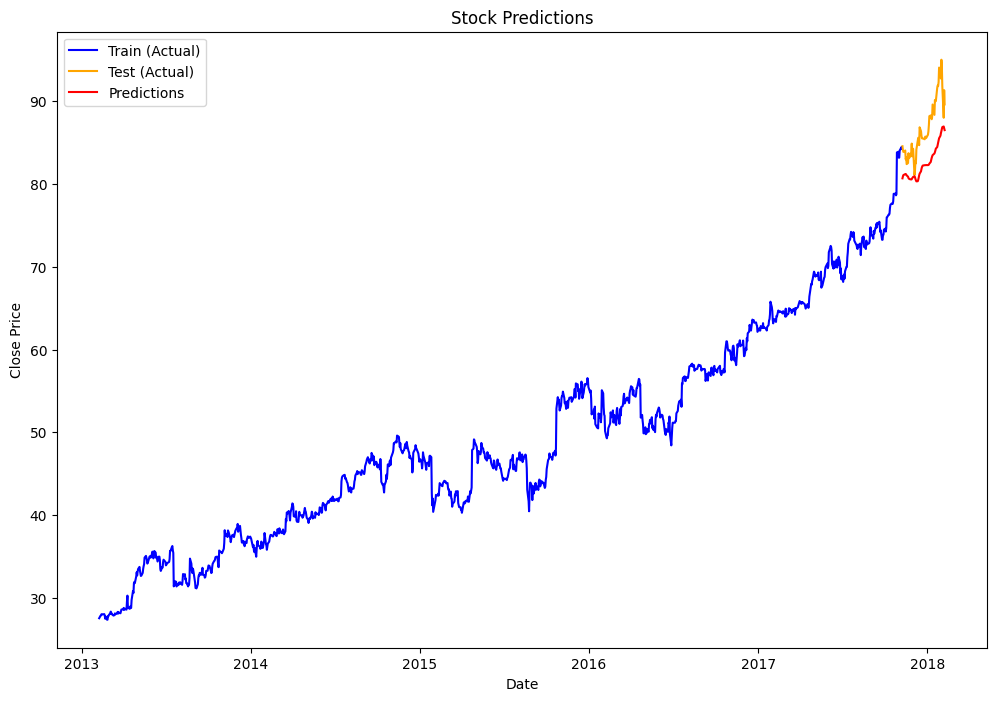

Test MAE: 4.2160
Test RMSE: 4.6282


In [ ]:
# Prepare for the LSTM Model (Sequential)
stock_close = data.filter(["close"])
dataset = stock_close.values #convert to numpy array
training_data_len = int(np.ceil(len(dataset) * 0.95))

# Preprocessing Stages
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[:training_data_len] #95% of all out data

X_train, y_train = [], []

# Create a sliding window for our stock (60 days)
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


# Build the Model
model_1 = keras.models.Sequential([
    keras.Input(shape = (60, 1)),
    keras.layers.LSTM(64, return_sequences = True),
    keras.layers.LSTM(64),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1),
])

model_1.summary()
model_1.compile(optimizer = "adam",
              loss = "mae",
              metrics = [keras.metrics.RootMeanSquaredError()])

# EarlyStopping ensures there are no wasted time training past the point of best generalization.
early_stop = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 20,
    min_delta = 0.005,
    restore_best_weights = True
)

# Watches the Validation Loss
checkpoint = keras.callbacks.ModelCheckpoint(
    "best_lstm.h5",
    monitor = "val_loss",
    save_best_only = True
)

# Training the model
training = model_1.fit(X_train, y_train, epochs = 100, batch_size = 32, shuffle = False, validation_split = 0.2, callbacks = [early_stop, checkpoint])

# Prep the test data
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]


for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))

# Make a Prediction
predictions = model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions)

train = data[:training_data_len]
test = data[training_data_len:].copy()

test["Predictions"] = predictions

# Plotting data
plt.figure(figsize = (12, 8))
plt.plot(train["date"], train["close"], label = "Train (Actual)", color = "blue")
plt.plot(test["date"], test["close"], label = "Test (Actual)", color = "orange")
plt.plot(test["date"], test["Predictions"], label = "Predictions", color = "red")
plt.title("Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

###First Plot (Train vs. Val MAE)

Both curves should trend downward and ideally settle at similar levels.

If training MAE keeps dropping but validation MAE flattens or creeps back up, that's a sign of overfitting.

###Second Plot (Train vs. Val RMSE)

RMSE punishes larger errors more heavily than MAE.

Diagnostics same like before.


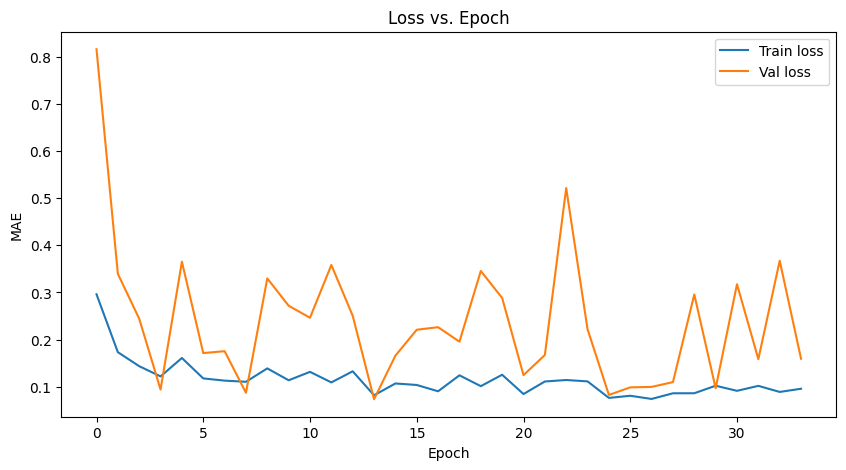

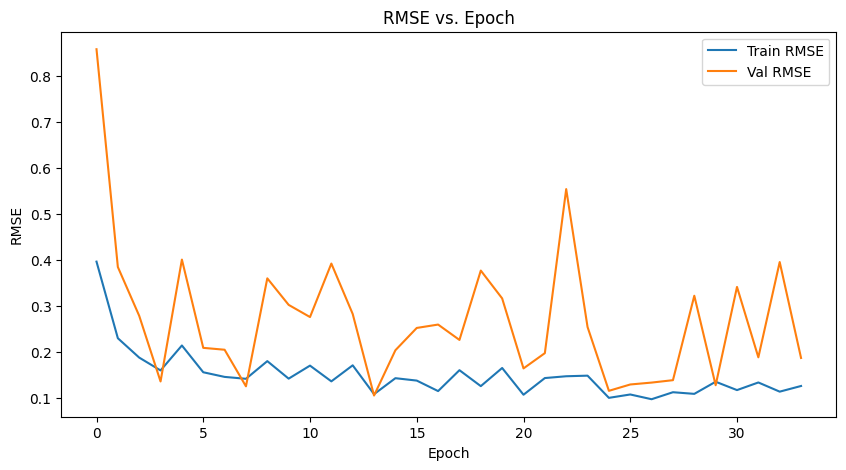

In [ ]:
# Grab the history dictionary, containing keys like "loss", "val_loss", "root_mean_squared_error", and "val_root_mean_squared_error"
history = training.history

# Plot Train vs Val MAE
plt.figure(figsize = (10, 5))
plt.plot(history["loss"], label = "Train loss")
plt.plot(history["val_loss"], label = "Val loss")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

# Plot Train vs. Val RMSE
plt.figure(figsize = (10, 5))
plt.plot(history["root_mean_squared_error"], label = "Train RMSE")
plt.plot(history["val_root_mean_squared_error"], label = "Val RMSE")
plt.title("RMSE vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

##Model 2 Summary

This second model correctly identifies the problem in the first model and only scaled on the training data. Most of the time, it predicts better than the previous model. The reason for this is probably because I implemented the validation set and early stopping for the previous model to prevent overfitting which means training MAE at that stop point will generally be higher but validation MAE (and by extension your true test MAE) will be lower.

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.5646 - root_mean_squared_error: 0.6750

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.5575 - root_mean_squared_error: 0.6682 - val_loss: 0.6737 - val_root_mean_squared_error: 0.7329
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2948 - root_mean_squared_error: 0.3481

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.2927 - root_mean_squared_error: 0.3460 - val_loss: 0.5396 - val_root_mean_squared_error: 0.5902
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2802 - root_mean_squared_error: 0.3293

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.2770 - root_mean_squared_error: 0.3264 - val_loss: 0.2566 - val_root_mean_squared_error: 0.3211
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.3153 - root_mean_squared_error: 0.3763 - val_loss: 0.5852 - val_root_mean_squared_error: 0.6332
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.2057 - root_mean_squared_error: 0.2499 - val_loss: 0.2837 - val_root_mean_squared_error: 0.3487
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1240 - root_mean_squared_error: 0.1596 - val_loss: 0.3059 - val_root_mean_squared_error: 0.3517
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1165 - root_mean_squared_error: 0.1500

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.1161 - root_mean_squared_error: 0.1496 - val_loss: 0.0972 - val_root_mean_squared_error: 0.1403
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.2049 - root_mean_squared_error: 0.2481 - val_loss: 0.3569 - val_root_mean_squared_error: 0.3978
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1564 - root_mean_squared_error: 0.1937 - val_loss: 0.1388 - val_root_mean_squared_error: 0.1960
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.1271 - root_mean_squared_error: 0.1647 - val_loss: 0.2190 - val_root_mean_squared_error: 0.2622
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.1076 - root_mean_squared_error: 0.1370 - val_loss: 0.1108 - val_root_mean_squared_error: 0.1551
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1339 - root_mean_squared_error: 0.1710

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.1328 - root_mean_squared_error: 0.1699 - val_loss: 0.0794 - val_root_mean_squared_error: 0.1161
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.1223 - root_mean_squared_error: 0.1571 - val_loss: 0.1208 - val_root_mean_squared_error: 0.1576
Epoch 14/100
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1351 - root_mean_squared_error: 0.1712

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.1330 - root_mean_squared_error: 0.1691 - val_loss: 0.0693 - val_root_mean_squared_error: 0.0924
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1400 - root_mean_squared_error: 0.1746

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.1388 - root_mean_squared_error: 0.1735 - val_loss: 0.0673 - val_root_mean_squared_error: 0.0916
Epoch 16/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.1011 - root_mean_squared_error: 0.1298 - val_loss: 0.0754 - val_root_mean_squared_error: 0.0956
Epoch 17/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0999 - root_mean_squared_error: 0.1294

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0995 - root_mean_squared_error: 0.1290 - val_loss: 0.0666 - val_root_mean_squared_error: 0.0891
Epoch 18/100
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1002 - root_mean_squared_error: 0.1318

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0992 - root_mean_squared_error: 0.1307 - val_loss: 0.0626 - val_root_mean_squared_error: 0.0856
Epoch 19/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0917 - root_mean_squared_error: 0.1191 - val_loss: 0.0762 - val_root_mean_squared_error: 0.1040
Epoch 20/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.1318 - root_mean_squared_error: 0.1642 - val_loss: 0.2274 - val_root_mean_squared_error: 0.2543
Epoch 21/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0870 - root_mean_squared_error: 0.1146 - val_loss: 0.0726 - val_root_mean_squared_error: 0.1040
Epoch 22/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0945 - root_mean_squared_error: 0.1225 - val_loss: 0.0849 - val_root_mean_squared_error: 0.1218
Epoch 23/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0880 - root_mean_squared_error: 0.1174 - val_loss: 0.1212 - val_root_mean_squared_error: 0.1509
Epoch 24/100
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - los

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0883 - root_mean_squared_error: 0.1198 - val_loss: 0.0553 - val_root_mean_squared_error: 0.0773
Epoch 25/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.1030 - root_mean_squared_error: 0.1324 - val_loss: 0.0650 - val_root_mean_squared_error: 0.0922
Epoch 26/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1285 - root_mean_squared_error: 0.1623 - val_loss: 0.1178 - val_root_mean_squared_error: 0.1581
Epoch 27/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0988 - root_mean_squared_error: 0.1296 - val_loss: 0.1919 - val_root_mean_squared_error: 0.2168
Epoch 28/100
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0835 - root_mean_squared_error: 0.1080

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0830 - root_mean_squared_error: 0.1075 - val_loss: 0.0545 - val_root_mean_squared_error: 0.0757
Epoch 29/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.1105 - root_mean_squared_error: 0.1402 - val_loss: 0.0600 - val_root_mean_squared_error: 0.0868
Epoch 30/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0797 - root_mean_squared_error: 0.1088 - val_loss: 0.0879 - val_root_mean_squared_error: 0.1208
Epoch 31/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0910 - root_mean_squared_error: 0.1203

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0907 - root_mean_squared_error: 0.1200 - val_loss: 0.0512 - val_root_mean_squared_error: 0.0737
Epoch 32/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0870 - root_mean_squared_error: 0.1120 - val_loss: 0.0539 - val_root_mean_squared_error: 0.0722
Epoch 33/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.1038 - root_mean_squared_error: 0.1340 - val_loss: 0.0601 - val_root_mean_squared_error: 0.0793
Epoch 34/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.1089 - root_mean_squared_error: 0.1409 - val_loss: 0.0517 - val_root_mean_squared_error: 0.0697
Epoch 35/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1082 - root_mean_squared_error: 0.1382 - val_loss: 0.0691 - val_root_mean_squared_error: 0.0997
Epoch 36/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0920 - root_mean_squared_error: 0.1204 - val_loss: 0.1851 - val_root_mean_squared_error: 0.2073
Epoch 37/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - los

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0916 - root_mean_squared_error: 0.1198 - val_loss: 0.0468 - val_root_mean_squared_error: 0.0672
Epoch 38/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0831 - root_mean_squared_error: 0.1073 - val_loss: 0.0750 - val_root_mean_squared_error: 0.1074
Epoch 39/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0909 - root_mean_squared_error: 0.1199 - val_loss: 0.1083 - val_root_mean_squared_error: 0.1345
Epoch 40/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0960 - root_mean_squared_error: 0.1223 - val_loss: 0.0764 - val_root_mean_squared_error: 0.1003
Epoch 41/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0826 - root_mean_squared_error: 0.1095 - val_loss: 0.0582 - val_root_mean_squared_error: 0.0747
Epoch 42/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0860 - root_mean_squared_error: 0.1106 - val_loss: 0.1013 - val_root_mean_squared_error: 0.1267
Epoch 43/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - lo

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0782 - root_mean_squared_error: 0.1036 - val_loss: 0.0462 - val_root_mean_squared_error: 0.0635
Epoch 45/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0743 - root_mean_squared_error: 0.1009 - val_loss: 0.0713 - val_root_mean_squared_error: 0.1018
Epoch 46/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0948 - root_mean_squared_error: 0.1210 - val_loss: 0.1567 - val_root_mean_squared_error: 0.1858
Epoch 47/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0921 - root_mean_squared_error: 0.1187 - val_loss: 0.1238 - val_root_mean_squared_error: 0.1405
Epoch 48/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0723 - root_mean_squared_error: 0.0947

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0721 - root_mean_squared_error: 0.0945 - val_loss: 0.0395 - val_root_mean_squared_error: 0.0581
Epoch 49/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0748 - root_mean_squared_error: 0.0975 - val_loss: 0.0491 - val_root_mean_squared_error: 0.0709
Epoch 50/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0753 - root_mean_squared_error: 0.0984 - val_loss: 0.1138 - val_root_mean_squared_error: 0.1477
Epoch 51/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.1032 - root_mean_squared_error: 0.1298 - val_loss: 0.1809 - val_root_mean_squared_error: 0.1958
Epoch 52/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0744 - root_mean_squared_error: 0.0986 - val_loss: 0.0401 - val_root_mean_squared_error: 0.0587
Epoch 53/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0794 - root_mean_squared_error: 0.1058 - val_loss: 0.0691 - val_root_mean_squared_error: 0.0971
Epoch 54/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - los

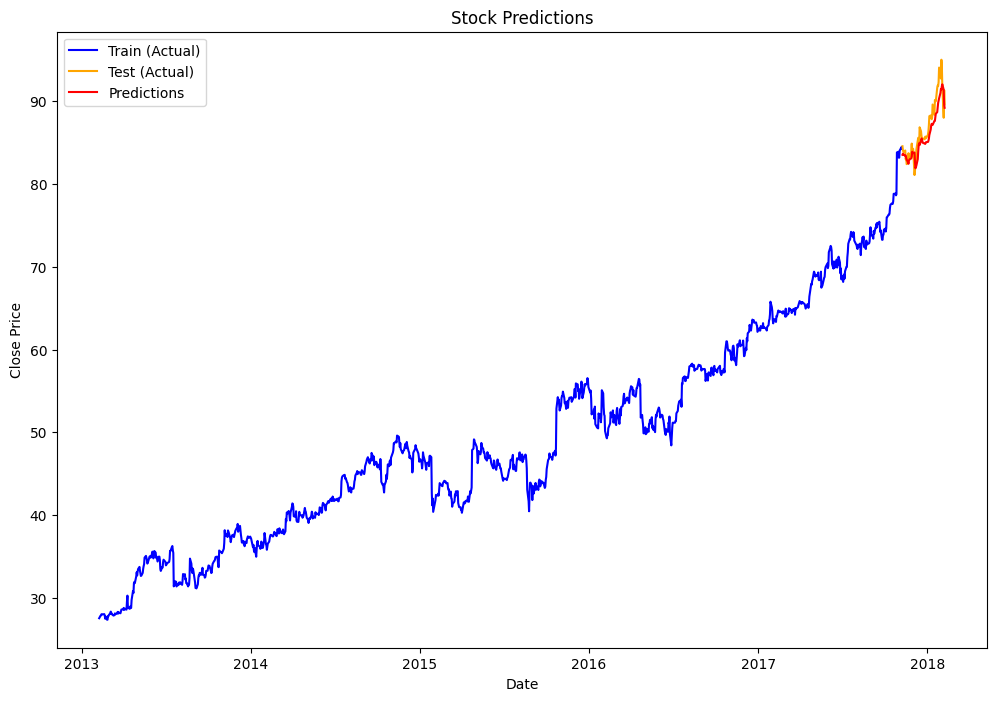

Test MAE: 1.2576
Test RMSE: 1.5818


In [ ]:
# Prepare for the LSTM Model (Sequential)
# We’re going to predict tomorrow’s closing price, so we only need that series.
stock_close = data.filter(["close"])
dataset = stock_close.values

# Include the last 60 points of train for the test window
training_data_len = int(np.ceil(len(dataset) * 0.95))
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len - 60:]

# Fit scaler on train only, then transform both
scaler = StandardScaler()
scaler.fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

# Build train sequences
X_train, y_train = [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i - 60: i, 0])
    y_train.append(train_scaled[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Build test sequences
X_test = []
for i in range(60, len(test_scaled)):
    X_test.append(test_scaled[i - 60: i, 0])

X_test = np.array(X_test)

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# Pull out the actual y_test from the raw dataset, unscaled
y_test = dataset[training_data_len:]
y_test = y_test.reshape(-1, 1)

# Build the Model
model_2 = keras.models.Sequential([
    keras.Input(shape = (60, 1)),
    keras.layers.LSTM(64, return_sequences = True),
    keras.layers.LSTM(64),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1),
])

model_2.summary()
model_2.compile(optimizer = "adam",
              loss = "mae",
              metrics = [keras.metrics.RootMeanSquaredError()])

# EarlyStopping ensures there are no wasted time training past the point of best generalization.
early_stop = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 20,
    min_delta = 0.005,
    restore_best_weights = True
)

# Watches the Validation Loss
checkpoint = keras.callbacks.ModelCheckpoint(
    "best_lstm.h5",
    monitor = "val_loss",
    save_best_only = True
)

# Training the model
training = model_2.fit(X_train, y_train, epochs = 100, batch_size = 32, shuffle = False, validation_split = 0.2, callbacks = [early_stop, checkpoint])

# Make a Prediction
predictions = model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions)

train = data[:training_data_len]
test = data[training_data_len:].copy()

test["Predictions"] = predictions

# Plotting data
plt.figure(figsize = (12, 8))
plt.plot(train["date"], train["close"], label = "Train (Actual)", color = "blue")
plt.plot(test["date"], test["close"], label = "Test (Actual)", color = "orange")
plt.plot(test["date"], test["Predictions"], label = "Predictions", color = "red")
plt.title("Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

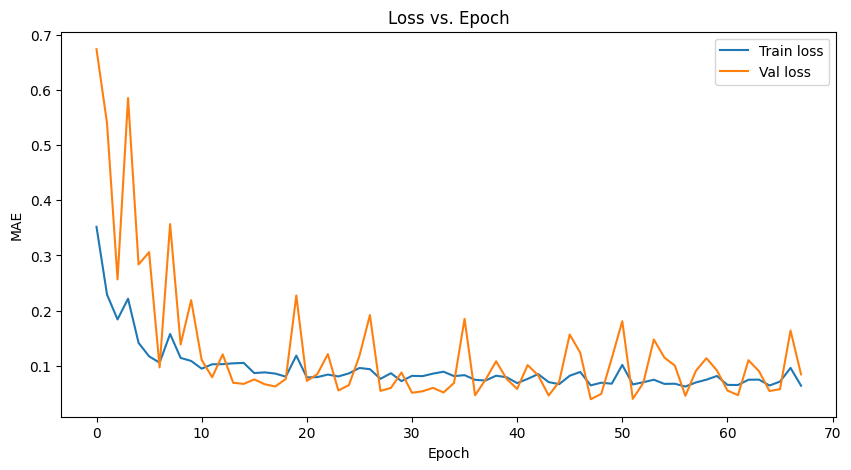

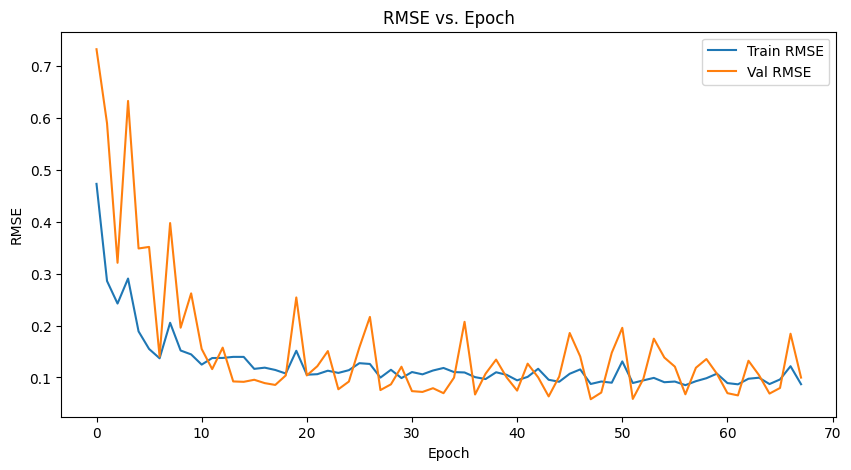

In [ ]:
# Grab the history dictionary, containing keys like "loss", "val_loss", "root_mean_squared_error", and "val_root_mean_squared_error"
history = training.history

# Plot Train vs Val MAE
plt.figure(figsize = (10, 5))
plt.plot(history["loss"], label = "Train loss")
plt.plot(history["val_loss"], label = "Val loss")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

# Plot Train vs. Val RMSE
plt.figure(figsize = (10, 5))
plt.plot(history["root_mean_squared_error"], label = "Train RMSE")
plt.plot(history["val_root_mean_squared_error"], label = "Val RMSE")
plt.title("RMSE vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()